In [154]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error



from sklearn.feature_selection import RFE
import statsmodels.formula.api as smf


In [155]:
df = pd.read_csv('cleaned_data.csv')
df["title_year"] = df["title_year"].astype(int)

In [156]:
df.columns

Index(['director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'gross', 'genres', 'actor_1_name',
       'movie_title', 'num_voted_users', 'cast_total_facebook_likes',
       'actor_3_name', 'facenumber_in_poster', 'plot_keywords',
       'movie_imdb_link', 'num_user_for_reviews', 'language', 'country',
       'content_rating', 'budget', 'title_year', 'actor_2_facebook_likes',
       'imdb_score', 'aspect_ratio', 'movie_facebook_likes', 'profit',
       'action', 'adventure', 'animation', 'biography', 'comedy', 'crime',
       'documentary', 'drama', 'family', 'fantasy', 'history', 'horror',
       'music', 'musical', 'mystery', 'romance', 'sci_fi', 'sport', 'thriller',
       'war', 'western'],
      dtype='object')

## Which Genre Is More Profitable?

In [157]:
# #organize data to plot avg yearly profit for each genre
# df['profit'] = df['gross'] - df['budget']
# df['year'] = df['title_year'].astype(int)

# #subset data to only include movies from 2000-latest year
# df = df[df['year'] >= 2008]
# #subsect data to only include movies from 2000-latest year
# #group by genre and year and find the average profit for each genre
# df = df.groupby(['genres', 'year']).mean()
# df = df.reset_index()
# df = df[['genres', 'year', 'gross']]
# df = df.sort_values(by=['year', 'gross'], ascending=False)
# df = df.groupby('genres').head(5)
# print(df)






No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


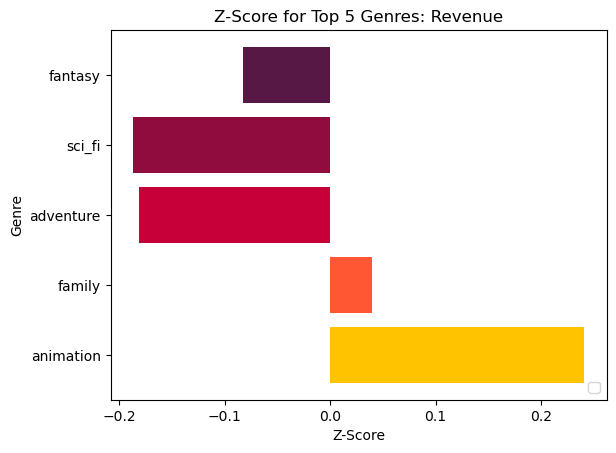

In [158]:
df_rev = df.copy()
# Define top 5 genres
top_5 = ['animation', 'family', 'adventure', 'sci_fi', 'fantasy']

# Drop irrelevant columns
df_rev = df_rev.drop(columns=['action', 'biography', 'comedy', 'crime', 'documentary', 'drama', 'history', 'horror', 'music', 'musical', 'mystery', 'romance', 'sport', 'thriller', 'war', 'western'])

# Format year column
df_rev['title_year'] = df_rev['title_year'].astype(str).str.extract('(\d{4})', expand=False).astype(float)

# Filter by top 5 genres
df_rev = df_rev[top_5 + ['title_year', 'gross']]
df_rev = pd.melt(df, id_vars=['title_year', 'gross'], value_vars=top_5, var_name='genre', value_name='dummy_value')
df_rev = df_rev[df_rev['dummy_value'] == 1]
df_rev = df_rev.drop(columns=['dummy_value'])

# Calculate z-score for gross profit
df_rev['z_score'] = (df_rev['gross'] - df_rev['gross'].mean()) / df_rev['gross'].std()

# Group by year and genre and calculate mean z-score
grouped = df_rev.groupby(['title_year', 'genre']).agg({'z_score': np.mean}).reset_index()

# Condense each of the 5 genres into 1 horizontal bar, use nice colors
for i, genre in enumerate(top_5):
    genre_df = grouped[grouped['genre'] == genre]
    plt.barh(y=i, width=genre_df['z_score'].mean(), color=['#FFC300', '#FF5733', '#C70039', '#900C3F', '#581845'][i])   

# Set plot properties
plt.yticks(range(len(top_5)), top_5)
plt.title('Z-Score for Top 5 Genres: Revenue')
plt.xlabel('Z-Score')
plt.ylabel('Genre')
plt.legend(loc='lower right')
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


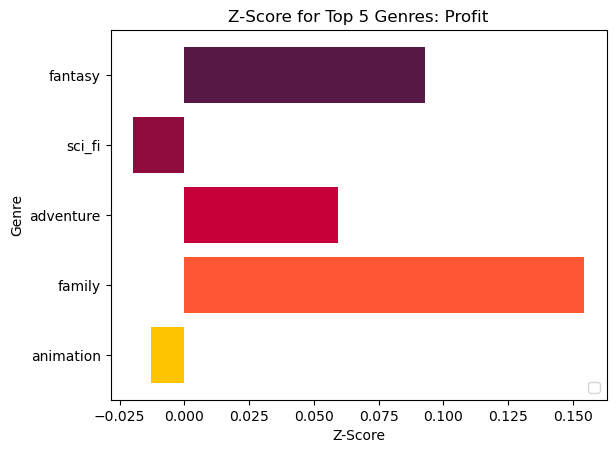

In [160]:
#Do same for profit
df_prof = df.copy()
# Define top 5 genres
top_5 = ['animation', 'family', 'adventure', 'sci_fi', 'fantasy']

# Drop irrelevant columns
df_prof = df_prof.drop(columns=['action', 'biography', 'comedy', 'crime', 'documentary', 'drama', 'history', 'horror', 'music', 'musical', 'mystery', 'romance', 'sport', 'thriller', 'war', 'western'])

# Format year column
df_prof['title_year'] = df_prof['title_year'].astype(int)

# Filter by top 5 genres
df_prof = df_prof[top_5 + ['title_year', 'profit']]
df_prof = pd.melt(df, id_vars=['title_year', 'profit'], value_vars=top_5, var_name='genre', value_name='dummy_value')
df_prof = df_prof[df_prof['dummy_value'] == 1]
df_prof = df_prof.drop(columns=['dummy_value'])

# Calculate z-score for gross profit
df_prof['z_score'] = (df_prof['profit'] - df_prof['profit'].mean()) / df_prof['profit'].std()

# Group by year and genre and calculate mean z-score
grouped = df_prof.groupby(['title_year', 'genre']).agg({'z_score': np.mean}).reset_index()

# Condense each of the 5 genres into 1 horizontal bar, use nice colors
for i, genre in enumerate(top_5):
    genre_df = grouped[grouped['genre'] == genre]
    plt.barh(y=i, width=genre_df['z_score'].mean(), color=['#FFC300', '#FF5733', '#C70039', '#900C3F', '#581845'][i])

# Set plot properties   
plt.yticks(range(len(top_5)), top_5)
plt.title('Z-Score for Top 5 Genres: Profit')
plt.xlabel('Z-Score')
plt.ylabel('Genre')
plt.legend(loc='lower right')
plt.show()


